In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/kaggle/input/widget-sales/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [3]:
df.shape

(500, 1)

In [4]:
df.isnull().sum()

widget_sales    0
dtype: int64

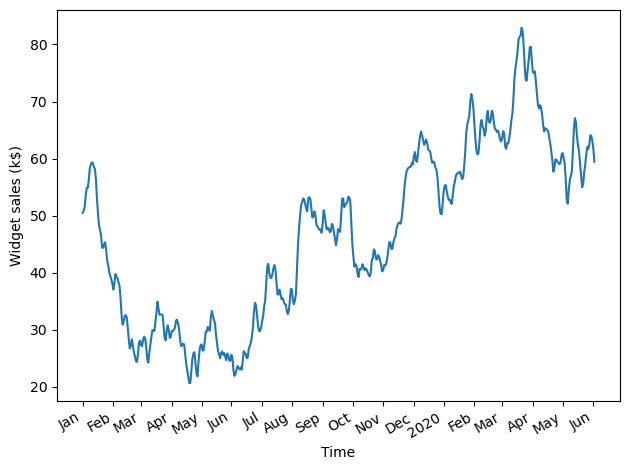

In [5]:
fig, ax = plt.subplots()
ax.plot(df['widget_sales']) 
ax.set_xlabel('Time') 
ax.set_ylabel('Widget sales (k$)') 
plt.xticks(
 [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
 ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']) 

fig.autofmt_xdate() 
plt.tight_layout() 

In [6]:
from statsmodels.tsa.stattools import adfuller

ADF_Statistics = adfuller(df['widget_sales'])
print(f'ADF Statistics : {ADF_Statistics[0]}')
print(f'P-Value : {ADF_Statistics[1]}')

ADF Statistics : -1.5121662069359063
P-Value : 0.5274845352272597


In [7]:
widget_sales_diff = np.diff(df['widget_sales'], n=1) 

In [8]:
ADF_result = adfuller(widget_sales_diff) 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341955
p-value: 7.076922818587346e-19


In [9]:
ADF_Statistics = adfuller(widget_sales_diff)
print(f'ADF Statistics : {ADF_Statistics[0]}')
print(f'P-Value : {ADF_Statistics[1]}')

ADF Statistics : -10.576657780341955
P-Value : 7.076922818587346e-19


This gives an ADF statistic of –10.6 and a p-value of 7 × 10–19. Therefore, with a large
negative ADF statistic and a p-value much smaller than 0.05, we can say that our series
is stationary.

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

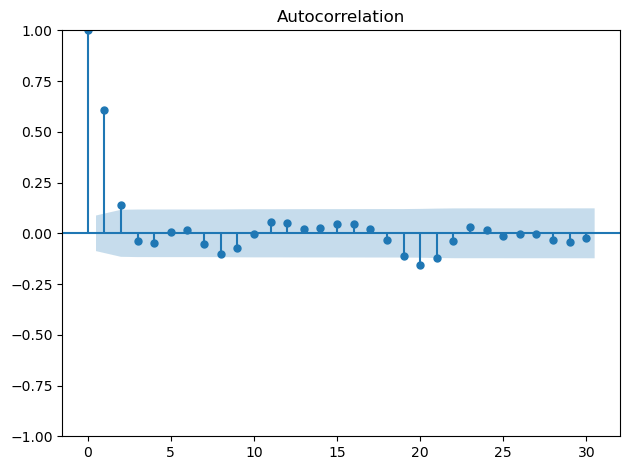

In [11]:
plot_acf(widget_sales_diff, lags=30); 
plt.tight_layout()

Notice how the coefficients are 
significant up until lag 2, and then they fall abruptly into the non-significance zone 
(shaded area) of the plot. There are some significant coefficients around lag 20, 
but this is likely due to chance, since they are non-significant between lags 3 and 
20 and after lag 20.

In [12]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff}) 
train = df_diff[:int(0.9*len(df_diff))] 
test = df_diff[int(0.9*len(df_diff)):] 

print(len(train))
print(len(test))

449
50


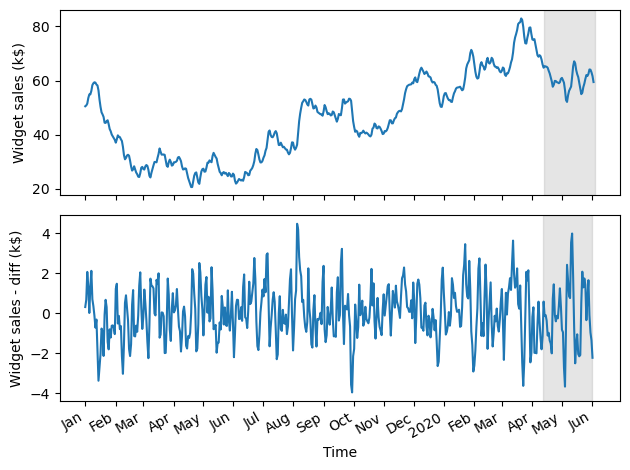

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True) 
ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)
plt.xticks(
 [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 
439, 468, 498], 
 ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [15]:
def rolling_forecast(df:pd.DataFrame, train_len:int, horizon:int, window:int, method:str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(start=0, end=i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:] 
            pred_MA.extend(oos_pred)
            
        return pred_MA


Source : https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html

Insample VS Outsample : https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts

`SARIMAXResults.get_prediction(start=None, end=None, dynamic=False, information_set='predicted', signal_only=False, index=None, exog=None, extend_model=None, extend_kwargs=None, **kwargs)`

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html

# Note : 

#### Forecasting:
`Out-of-sample` forecasts are produced using the forecast or get_forecast methods from the results object.

1. The `forecast` method gives only point forecasts.
2. The `get_forecast` method is more general, and also allows constructing confidence intervals.

#### Prediction vs Forecasting:

The results objects also contain two methods that all for both `in-sample` fitted values and `out-of-sample` forecasting. They are predict and get_prediction. The predict method only returns point predictions (similar to forecast), while the get_prediction method also returns additional results (similar to get_forecast).

In general, if your interest is out-of-sample forecasting, it is easier to stick to the forecast and get_forecast methods.

#### In-Sample Vs Out-Sample: 

By the "sample" it is meant the data sample that you are using to fit the model.

First - you have a sample
Second - you fit a model on the sample
Third - you can use the model for forecasting

If you are forecasting for an observation that was part of the data sample - it is in-sample forecast.

If you are forecasting for an observation that was not part of the data sample - it is out-of-sample forecast.

"if you use data 1990-2013 to fit the model and then you forecast for 2011-2013, it's in-sample forecast. but if you only use 1990-2010 for fitting the model and then you forecast 2011-2013, then its out-of-sample forecast."

In [16]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [17]:
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA


pred_df.head(10)

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,[-1.8036576833901847],-1.078833
450,0.580967,0.034319,[-1.8036576833901847],-0.273309
451,-0.144902,0.032861,[0.5809670763886885],0.781223
452,-0.096564,0.032861,[0.5809670763886885],0.234969
453,-0.372334,0.032183,[-0.09656423003376347],0.168994
454,-1.118891,0.032183,[-0.09656423003376347],0.115810
455,-0.979693,0.028764,[-1.118890734142198],-0.795666
456,-1.369431,0.028764,[-1.118890734142198],-0.191286
457,-1.517477,0.023498,[-1.3694314960571816],-0.922824
458,-2.006735,0.023498,[-1.3694314960571816],-0.254060


In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497544618


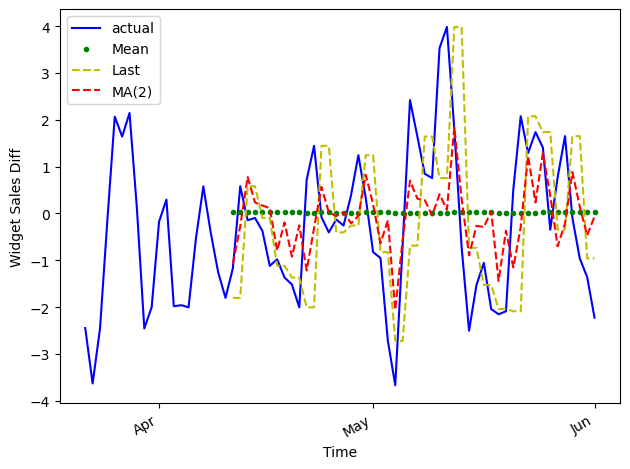

In [19]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'][-70:],  'b-', label='actual')
ax.plot(pred_df['pred_mean'],  'g.', label='Mean')
ax.plot(pred_df['pred_last_value'],  'y--', label='Last')
ax.plot(pred_df['pred_MA'],  'r--', label='MA(2)')

ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales Diff')
ax.legend(loc=2)

plt.xticks([439, 468, 498], ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

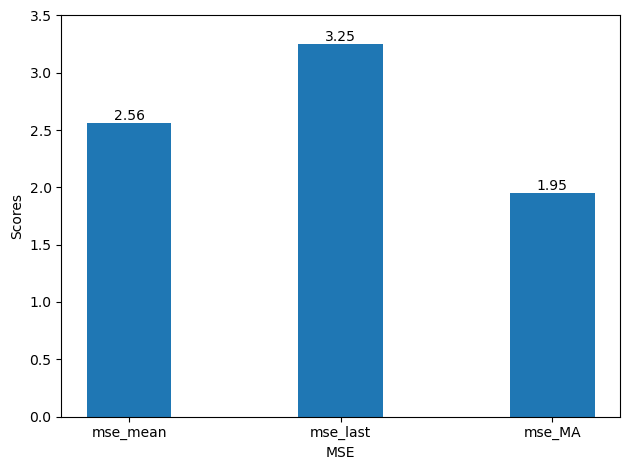

In [20]:
fig, ax = plt.subplots()

x = ['mse_mean', 'mse_last', 'mse_MA']
y = [mse_mean, mse_last, mse_MA]
y = np.round(np.array(y),2)

ax.bar(x, y, width=0.4)
ax.set_xlabel('MSE')
ax.set_ylabel('Scores')
ax.set_ylim(0,3.50)

# for index, value in enumerate(y):
#     plt.text(x=index, y=value+1, s=str(value), ha='center', va='bottom')
    
ax.bar_label(ax.containers[0], label_type='edge')

plt.xticks([0,1,2])
plt.tight_layout()

In [21]:
df['pred_widget_sales'] = pd.Series()

In [22]:
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

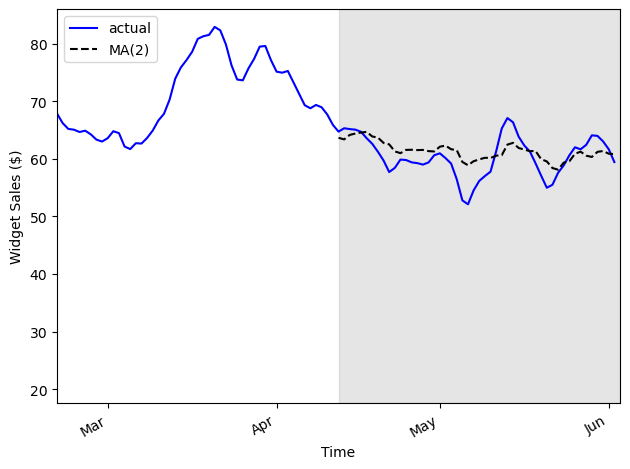

In [23]:
fig, ax = plt.subplots()

ax.plot(df.widget_sales, 'b-', label='actual')
ax.plot(df.pred_widget_sales, 'k--', label='MA(2)')

ax.set_xlabel("Time")
ax.set_ylabel('Widget Sales ($)')

ax.set_xlim(400,500)
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(
 [409, 439, 468, 498], 
 ['Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

The final step is to report the MSE on the original dataset.

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.32447092447664


This prints out an MAE of 2.32. Therefore, our predictions are, on average, off by
$2,320, either above or below the actual value. Remember that our data has units of
thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute
difference.